# Motivation Figures: Baseline System Limitations

These figures demonstrate the problems with baseline routing in multi-agent systems:
1. **Query distribution imbalance** - Some models are overloaded while others remain idle
2. **Latency increases with load** - Higher arrival rates cause longer response times
3. **Queue buildup** - Overloaded models accumulate waiting requests
4. **Resource underutilization** - System capacity is poorly utilized

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for publication-quality figures
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 11

# Load data
DATA_PATH = '../logs/motivation_plot_generator_data/baseline_motivation_sweep_100.csv'
df = pd.read_csv(DATA_PATH)

# Separate episode and step records
episode_df = df[df.record_type == 'episode'].copy()
step_df = df[df.record_type == 'step'].copy()

# Create short model names for plotting
model_name_map = {
    'Qwen/Qwen2.5-Coder-14B-Instruct': 'Qwen-14B',
    'mistralai/Mistral-Small-24B-Instruct-2501': 'Mistral-24B',
    'meta-llama/Llama-3.2-3B-Instruct': 'Llama-3B',
    'meta-llama/Llama-3.1-8B-Instruct': 'Llama-8B',
    'deepseek-ai/DeepSeek-R1-Distill-Qwen-32B': 'DeepSeek-32B'
}
step_df.loc[:, 'model_short'] = step_df['llm_name'].map(model_name_map)

print(f"Total episodes: {len(episode_df)}")
print(f"Total LLM calls (steps): {len(step_df)}")
print(f"Arrival rates: {sorted(step_df['arrival_rate'].unique())}")
print(f"Models: {list(step_df['model_short'].unique())}")

Total episodes: 500
Total LLM calls (steps): 2885
Arrival rates: [np.float64(10.0), np.float64(30.0), np.float64(50.0), np.float64(70.0), np.float64(90.0)]
Models: ['Qwen-14B', 'Llama-3B', 'Mistral-24B', 'Llama-8B', 'DeepSeek-32B']


## Figure 1: Query Distribution Imbalance Across Arrival Rates

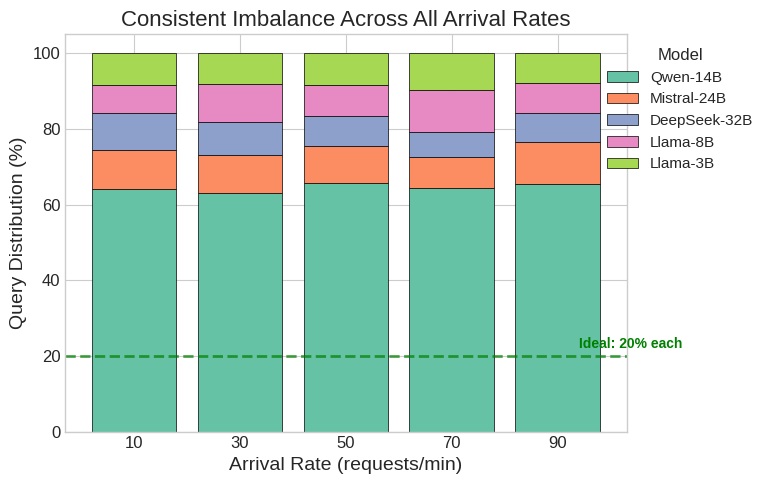

In [20]:
fig, ax = plt.subplots(figsize=(8, 5))

colors = sns.color_palette('Set2', n_colors=5)
model_order = ['Qwen-14B', 'Mistral-24B', 'DeepSeek-32B', 'Llama-8B', 'Llama-3B']

# Query distribution across ALL arrival rates - stacked bar
ar_comparison = step_df.groupby(['arrival_rate', 'model_short']).size().unstack(fill_value=0)
ar_comparison = ar_comparison[model_order]

# Calculate percentages
ar_pct = ar_comparison.div(ar_comparison.sum(axis=1), axis=0) * 100

# Plot stacked percentage bar
ar_pct.plot(kind='bar', stacked=True, ax=ax, color=colors, edgecolor='black', linewidth=0.5, width=0.8)
ax.set_xlabel('Arrival Rate (requests/min)')
ax.set_ylabel('Query Distribution (%)')
ax.set_title('Consistent Imbalance Across All Arrival Rates')
ax.legend(title='Model', loc='upper right', bbox_to_anchor=(1.25, 1))
ax.tick_params(axis='x', rotation=0)
ax.set_xticklabels([f'{int(x)}' for x in ar_comparison.index])
ax.axhline(y=20, color='green', linestyle='--', linewidth=2, alpha=0.7)
ax.annotate('Ideal: 20% each', xy=(4.2, 22), fontsize=10, color='green', fontweight='bold')

plt.tight_layout()
plt.show()

## Figure 2: Latency Increases with Load

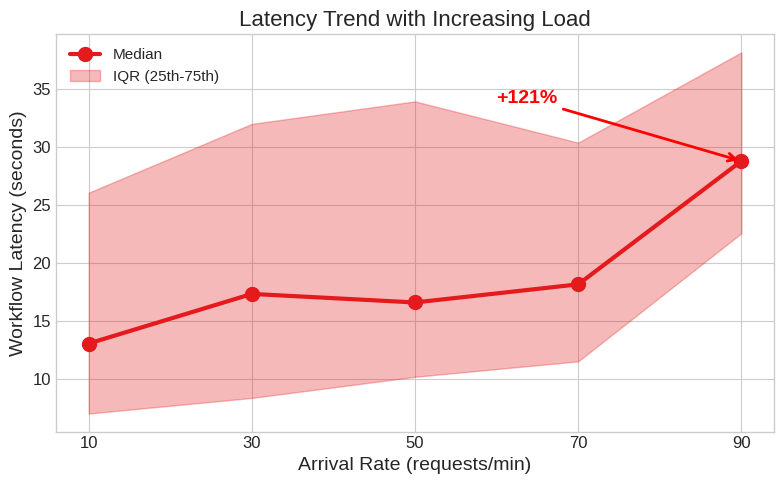

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))

arrival_rates = sorted(step_df['arrival_rate'].unique())

# Line plot with median and IQR
latency_stats = step_df.groupby('arrival_rate')['workflow_latency_seconds'].agg(
    ['median', lambda x: np.percentile(x, 75), lambda x: np.percentile(x, 25)]
)
latency_stats.columns = ['median', 'p75', 'p25']

ax.plot(arrival_rates, latency_stats['median'], 'o-', 
        linewidth=3, markersize=10, color='#e41a1c', label='Median')
ax.fill_between(arrival_rates, latency_stats['p25'], latency_stats['p75'],
                alpha=0.3, color='#e41a1c', label='IQR (25th-75th)')

ax.set_xlabel('Arrival Rate (requests/min)')
ax.set_ylabel('Workflow Latency (seconds)')
ax.set_title('Latency Trend with Increasing Load')
ax.set_xticks(arrival_rates)
ax.legend(loc='upper left')

# Highlight the increase from lowest to highest
low_lat = latency_stats.loc[10.0, 'median']
high_lat = latency_stats.loc[90.0, 'median']
increase_pct = ((high_lat / low_lat) - 1) * 100
ax.annotate(f'+{increase_pct:.0f}%', xy=(90, high_lat), xytext=(60, high_lat + 5),
            fontsize=14, fontweight='bold', color='red',
            arrowprops=dict(arrowstyle='->', color='red', lw=2))

plt.tight_layout()
plt.show()

## Figure 3: Running Requests - Qwen Overloaded

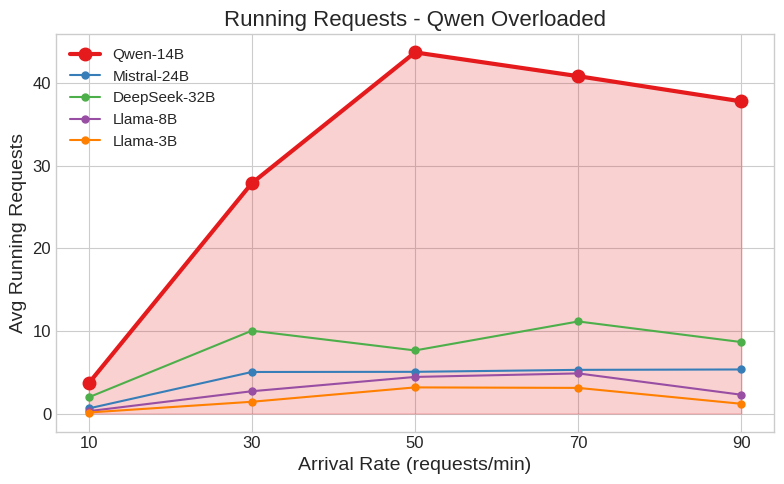

In [22]:
fig, ax = plt.subplots(figsize=(8, 5))

model_order = ['Qwen-14B', 'Mistral-24B', 'DeepSeek-32B', 'Llama-8B', 'Llama-3B']
arrival_rates = sorted(step_df['arrival_rate'].unique())

# Running requests trend by model across arrival rates
running_by_model = step_df.groupby(['arrival_rate', 'model_short'])['llm_running'].mean().unstack()
running_by_model = running_by_model[model_order]

colors_line = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']
for i, model in enumerate(model_order):
    lw = 3 if model == 'Qwen-14B' else 1.5
    ms = 9 if model == 'Qwen-14B' else 5
    ax.plot(arrival_rates, running_by_model[model], 'o-', 
            linewidth=lw, markersize=ms, label=model, color=colors_line[i])

ax.set_xlabel('Arrival Rate (requests/min)')
ax.set_ylabel('Avg Running Requests')
ax.set_title('Running Requests - Qwen Overloaded')
ax.set_xticks(arrival_rates)
ax.legend(loc='upper left')

# Shade Qwen area
ax.fill_between(arrival_rates, running_by_model['Qwen-14B'], alpha=0.2, color='#e41a1c')

plt.tight_layout()
plt.show()

## Figure 4: Load vs Memory Utilization Imbalance

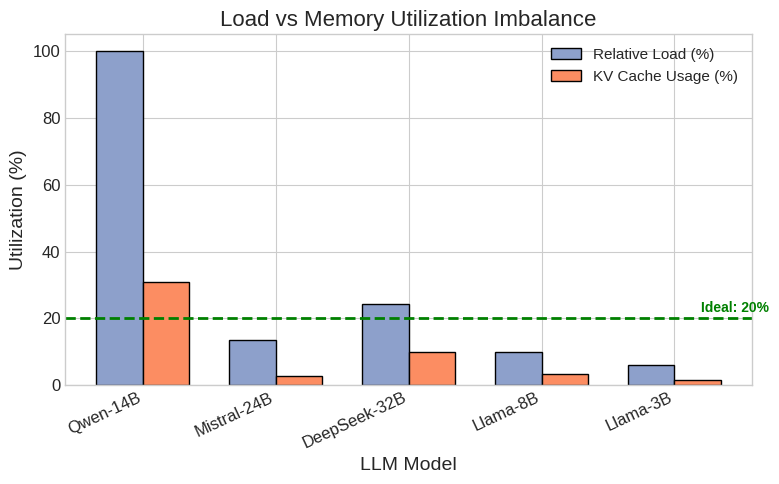

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))

model_order = ['Qwen-14B', 'Mistral-24B', 'DeepSeek-32B', 'Llama-8B', 'Llama-3B']

# Calculate utilization metrics per model
model_util = step_df.groupby('model_short').agg({
    'llm_running': 'mean',
    'llm_kv_cache_usage': 'mean',
}).round(3)
model_util.columns = ['avg_running', 'avg_kv_cache']
model_util = model_util.reindex(model_order)

# Normalize to show relative utilization
max_running = model_util['avg_running'].max()
model_util['load_pct'] = model_util['avg_running'] / max_running * 100
model_util['kv_pct'] = model_util['avg_kv_cache'] * 100

x = np.arange(len(model_order))
width = 0.35

# Plot with clear contrast
bars1 = ax.bar(x - width/2, model_util['load_pct'], width,
               label='Relative Load (%)', color='#8da0cb', edgecolor='black')
bars2 = ax.bar(x + width/2, model_util['kv_pct'], width,
               label='KV Cache Usage (%)', color='#fc8d62', edgecolor='black')

ax.set_xlabel('LLM Model')
ax.set_ylabel('Utilization (%)')
ax.set_title('Load vs Memory Utilization Imbalance')
ax.set_xticks(x)
ax.set_xticklabels(model_order, rotation=25, ha='right')
ax.legend(loc='upper right')

# Add ideal distribution line
ax.axhline(y=20, color='green', linestyle='--', linewidth=2)
ax.text(4.2, 22, 'Ideal: 20%', fontsize=10, color='green', fontweight='bold')

plt.tight_layout()
plt.show()